In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import markov_sim as markov
import json
import os
from datetime import datetime
from dateutil import parser
from hampel import hampel
import time
import copy
import preprocessing as p
import score_inference as score

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'
os.environ['LD_LIBRARY_PATH'] = '$LD_LIBRARY_PATH:/opt/rocm-5.3.0/lib'



In [2]:
def get_data(file):
    data_list = []
    for line in open(file, 'r'):
        data_list.append(json.loads(line))

    with open(file, 'r') as f:
        top = f.readline()
        top = json.loads(top)

    runner_id = top['mc'][0]['marketDefinition']['runners'][0]['id']
    runner_id_2 = top['mc'][0]['marketDefinition']['runners'][1]['id']
    market_datetime = parser.parse(data_list[-1]['mc'][0]['marketDefinition']['marketTime'])
    r1_result = data_list[-1]['mc'][0]['marketDefinition']['runners'][0]['status']
    market_timestamp = datetime.timestamp(market_datetime) * 1000
    return data_list, runner_id, runner_id_2, r1_result, market_timestamp


def get_list(runner_id, data_list, market_timestamp):
    # Create list for each runner
    runner_list = []
    for instance in data_list:
        if instance['pt'] > market_timestamp:
            if instance['mc'][0]['rc']:
                # Check for runner id
                temp_dict = {k: v for (k, v) in instance['mc'][0]['rc'][0].items() if v == runner_id}
                if temp_dict:
                    # Append runner info
                    runner_list.append([instance['mc'][0]['rc'][0], instance['pt']])
                elif len(instance['mc'][0]['rc']) > 1:
                    # If more than one runner
                    temp_dict_2 = {k: v for (k, v) in instance['mc'][0]['rc'][1].items() if v == runner_id}
                    if temp_dict_2:
                        runner_list.append([instance['mc'][0]['rc'][1], instance['pt']])
    return runner_list


def convert_odds(runner_list):
    # Convert to back/lay/last traded odds

    list = []

    for item in runner_list:
        if 'ltp' in item[0]:
            list.append([item[0]['ltp'], item[1]])

    del list[-1]
    arr = np.array(list)
    arr = arr[arr[:, 0] != 0]
    implied_odds = np.array([1 / arr[:, 0], arr[:, 1]]).T

    return implied_odds


# Find avg ltp odds
def odds_avg(runner_1, runner_2, r1_result):
    if runner_1[-1, 1] > runner_2[-1, 1]:
        if runner_1[1, 1] > runner_2[1, 1]:
            timestamps = np.arange(round(runner_2[1, 1], -2), round(runner_1[-1, 1] + 1, -2), 100)
        else:
            timestamps = np.arange(round(runner_1[1, 1], -2), round(runner_1[-1, 1] + 1, -2), 100)
    else:
        if runner_1[1, 1] > runner_2[1, 1]:
            timestamps = np.arange(round(runner_2[1, 1], -2), round(runner_2[-1, 1] + 1, -2), 100)
        else:
            timestamps = np.arange(round(runner_1[1, 1], -2), round(runner_2[-1, 1] + 1, -2), 100)

    odds = np.zeros(np.shape(timestamps))
    df_timestamps = pd.Series(timestamps)

    df_datetime = pd.to_datetime(df_timestamps, unit='ms')

    df = pd.DataFrame({'runner 1': odds, '1 - runner 2': odds}, index=df_datetime)

    for index, time in enumerate(runner_1[:, 1]):
        df['runner 1'].loc[pd.to_datetime(round(time, -2), unit='ms')] = runner_1[index, 0]

    for index, time in enumerate(runner_2[:, 1]):
        df['1 - runner 2'].loc[pd.to_datetime(round(time, -2), unit='ms')] = 1 - runner_2[index, 0]

    df.replace(0, np.nan, inplace=True)
    df.interpolate(method='time', limit_direction='both', inplace=True)
    df['avg'] = df.mean(axis=1)
    df_avg_odds = df.resample('2000ms').last()
    last_index = df_avg_odds.last_valid_index() + pd.Timedelta(2, 'sec')
    final_index = last_index + pd.Timedelta(12, 'sec')
    df_datetime = pd.date_range(last_index, final_index, freq='2000ms')
    print(df_datetime)
    if r1_result == 'WINNER':
        df_ones = pd.DataFrame({'runner 1': np.ones(7), '1 - runner 2': np.ones(7), 'avg': np.ones(7)}, index=df_datetime)
        df_avg_odds = pd.concat([df_avg_odds, df_ones])
    else:
        df_zeros = pd.DataFrame({'runner 1': np.zeros(7), '1 - runner 2': np.zeros(7), 'avg': np.zeros(7)}, index=df_datetime)
        df_avg_odds = pd.concat([df_avg_odds, df_zeros])
    print(df_avg_odds)
    return df_avg_odds

def get_best_pricevol(runner_list, price, vol):
# Function to get best lay and back information
    back_list = []
    lay_list = []

    back_vol = []
    lay_vol = []

    for item in runner_list:
        if 'atl' in item[0]:
            if len(item[0]['atl']) > 1:
                temp = []
                for i in item[0]['atl']:
                    if i[1] != 0:
                        temp.append(i[0])
                if temp:
                    temp = np.array(temp)
                    back_list.append([temp.min(), item[1]])
                    back_vol.append([item[0]['atl'][temp.argmax()][1], item[1]])
            else:
                if item[0]['atl'][0][1] != 0:
                    back_list.append([item[0]['atl'][0][0], item[1]])
                    back_vol.append([item[0]['atl'][0][1], item[1]])

    for item in runner_list:
        if 'atb' in item[0]:
            if len(item[0]['atb']) > 1:
                temp = []
                for i in item[0]['atb']:
                    if i[1] != 0:
                        temp.append(i[0])
                if temp:
                    temp = np.array(temp)
                    lay_list.append([temp.max(), item[1]])
                    lay_vol.append([item[0]['atb'][temp.argmax()][1], item[1]])
            else:
                if item[0]['atb'][0][1] != 0:
                    lay_list.append([item[0]['atb'][0][0], item[1]])
                    lay_vol.append([item[0]['atb'][0][1], item[1]])

    del back_list[-1], lay_list[-1], back_vol[-1], lay_vol[-1]

    back_vol_arr = np.array(back_vol)
    lay_vol_arr = np.array(lay_vol)
    back_arr = np.array(back_list)
    lay_arr = np.array(lay_list)

    back_series = pd.Series(back_arr[:, 0], index=pd.to_datetime(back_arr[:, 1], unit='ms'))
    lay_series = pd.Series(lay_arr[:, 0], index=pd.to_datetime(lay_arr[:, 1], unit='ms'))
    back_vol_series = pd.Series(back_vol_arr[:, 0], index=pd.to_datetime(back_vol_arr[:, 1], unit='ms'))
    lay_vol_series = pd.Series(lay_vol_arr[:, 0], index=pd.to_datetime(lay_vol_arr[:, 1], unit='ms'))
# Apply hampel filter to remove outliers
    back_outliers = hampel(back_series, window_size=80)
    lay_outliers = hampel(lay_series, window_size=80)
    back_vol_outliers = hampel(back_vol_series, window_size=15)
    lay_vol_outliers = hampel(lay_vol_series, window_size=15)

    back_arr = np.delete(back_arr, back_outliers, axis=0)
    lay_arr = np.delete(lay_arr, lay_outliers, axis=0)
    back_vol_arr = np.delete(back_vol_arr, back_vol_outliers, axis=0)
    lay_vol_arr = np.delete(lay_vol_arr, lay_vol_outliers, axis=0)

    if price and not vol:
        return back_arr, lay_arr
    elif vol and not price:
        return back_vol_arr, lay_vol_arr

    return back_arr, lay_arr, back_vol_arr, lay_vol_arr

def best_available_df(runner_list, start, end):
# Get back and lay information and calculate spread and price up probability
    end_time = end + pd.Timedelta(120, 'sec')
    df_datetime = pd.date_range(start, end_time, freq='100ms')
    df_datetime = df_datetime.floor('100ms')
    dt_shape = np.zeros(df_datetime.shape)

    back_arr, lay_arr, back_vol_arr, lay_vol_arr = get_best_pricevol(runner_list, True, True)

    df = pd.DataFrame({'back': dt_shape, 'lay': dt_shape, 'back_vol': dt_shape, 'lay_vol': dt_shape}, index=df_datetime)

    for index, time in enumerate(back_arr[:, 1]):
        df['back'].loc[pd.to_datetime(round(time, -2), unit='ms')] = back_arr[index, 0]
    for index, time in enumerate(lay_arr[:, 1]):
        df['lay'].loc[pd.to_datetime(round(time, -2), unit='ms')] = lay_arr[index, 0]

    for index, time in enumerate(back_vol_arr[:, 1]):
        df['back_vol'].loc[pd.to_datetime(round(time, -2), unit='ms')] = back_vol_arr[index, 0]
    for index, time in enumerate(lay_vol_arr[:, 1]):
        df['lay_vol'].loc[pd.to_datetime(round(time, -2), unit='ms')] = lay_vol_arr[index, 0]

    df.replace(0, np.nan, inplace=True)
    df.interpolate(method='time', limit_direction='both', inplace=True)

    _2000ms = df.index.floor('2000ms')
    idx_back = df.groupby(_2000ms)['back'].idxmin()
    idx_lay = df.groupby(_2000ms)['lay'].idxmax()
    df = df.resample('2000ms').mean().assign(back=df.loc[idx_back]['back'].values,
                                            back_vol=df.loc[idx_back]['back_vol'].values,
                                            lay=df.loc[idx_lay]['lay'].values,
                                            lay_vol=df.loc[idx_lay]['lay_vol'].values)

    df_best = df.rolling('60S').mean()
    df_best = df_best.loc[start:end]
    # last_index = end + pd.Timedelta(1, 'sec')
    # final_index = last_index + pd.Timedelta(59, 'sec')
    # df_datetime_new = pd.date_range(last_index, final_index, freq='2000ms')
    # print(end, last_index)
    # if r1_result == 'WINNER':
    #     df_ones = pd.DataFrame({'back': np.repeat(1000, 60), 'back_vol': np.zeros(60), 'lay': np.repeat(1000, 60), 'lay_vol': np.repeat(0.001, 60)}, index=df_datetime_new)
    #     df_best = pd.concat([df_best, df_ones])
    # else:
    #     df_zeros = pd.DataFrame({'back': np.ones(60), 'back_vol': np.zeros(60), 'lay': np.ones(60), 'lay_vol': np.repeat(0.001, 60)}, index=df_datetime_new)
    #     df_best = pd.concat([df, df_zeros])
    df_best['back-lay avg'] = df_best[['back', 'lay']].mean(axis=1)
    df_best['spread'] = df_best['back'] - df_best['lay']
    df_best['vol diff'] = df_best['back_vol'] - df_best['lay_vol']
    df_best['uncertainty'] = df_best['spread'] / df_best['back-lay avg']
    df_pup = df_best['back_vol'] / ( df_best['back_vol'] + df_best['lay_vol'] )
    df_pup.name = 'pup'
    df_best = pd.concat([df_best, df_pup], axis=1)
    df_best.fillna(method='ffill', inplace=True)

    return df_best

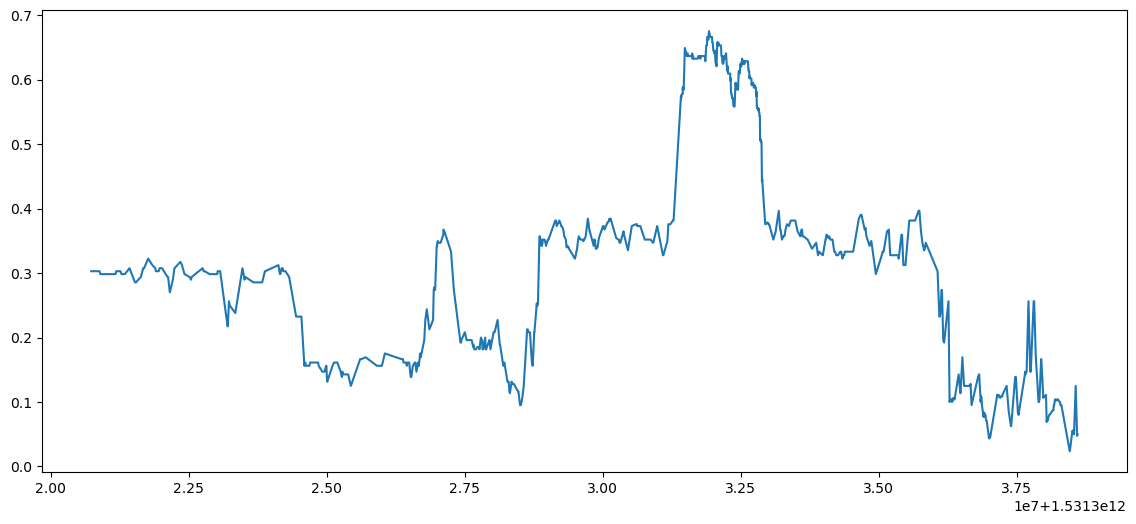

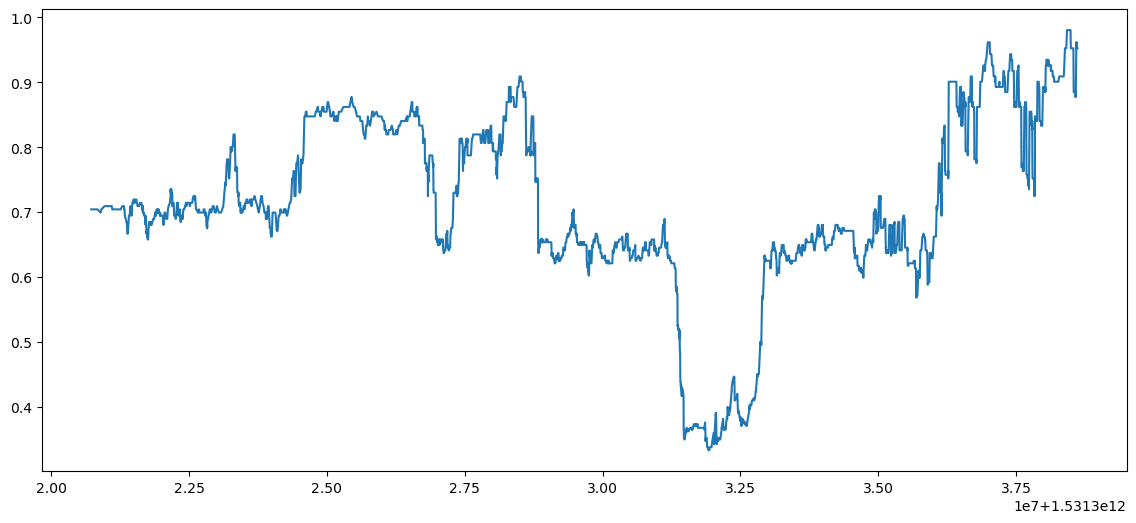

In [3]:
file = 'Wimbledon/1.145414064.json'
data_list, runner_id, runner_id_2, r1_result, market_timestamp = get_data(file)
runner_list_1 = get_list(runner_id, data_list, market_timestamp)
runner_list_2 = get_list(runner_id_2, data_list, market_timestamp)
runner_odds_1 = convert_odds(runner_list_1)
runner_odds_2 = convert_odds(runner_list_2)
plt.figure(figsize=(14,6))
plt.plot(runner_odds_1[:, 1], runner_odds_1[:, 0])
plt.figure(figsize=(14,6))
plt.plot(runner_odds_2[:, 1], runner_odds_2[:, 0])


In [4]:
df = odds_avg(runner_odds_1, runner_odds_2, r1_result)

DatetimeIndex(['2018-07-11 19:50:16', '2018-07-11 19:50:18',
               '2018-07-11 19:50:20', '2018-07-11 19:50:22',
               '2018-07-11 19:50:24', '2018-07-11 19:50:26',
               '2018-07-11 19:50:28'],
              dtype='datetime64[ns]', freq='2000L')
                     runner 1  1 - runner 2       avg
2018-07-11 14:52:06   0.30303      0.295775  0.299402
2018-07-11 14:52:08   0.30303      0.295775  0.299402
2018-07-11 14:52:10   0.30303      0.295775  0.299402
2018-07-11 14:52:12   0.30303      0.295775  0.299402
2018-07-11 14:52:14   0.30303      0.295775  0.299402
...                       ...           ...       ...
2018-07-11 19:50:20   0.00000      0.000000  0.000000
2018-07-11 19:50:22   0.00000      0.000000  0.000000
2018-07-11 19:50:24   0.00000      0.000000  0.000000
2018-07-11 19:50:26   0.00000      0.000000  0.000000
2018-07-11 19:50:28   0.00000      0.000000  0.000000

[8952 rows x 3 columns]


0.29737452899816286
0.628
0.662


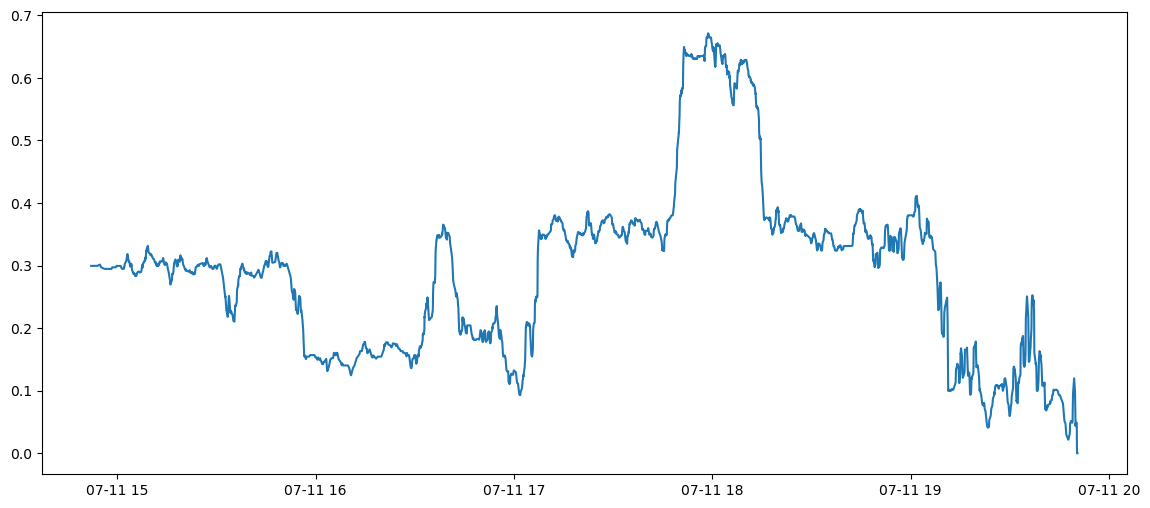

In [5]:
plt.figure(figsize=(14,6))
plt.plot(df['avg'])
first_odds = df['avg'].iloc[0:300].mean()
print(first_odds)
r1, r2 = score.get_serve_prob(first_odds)
r1 = r1.values[0]
r2 = r2.values[0]
print(r1)
print(r2)

In [6]:
start = df.first_valid_index()
end = df.last_valid_index()
df_score = score.get_score_time_series(r1, r2, df['avg'])

Match finished at 2-3


In [7]:
df_score

,r1_setscore,r2_setscore
2018-07-11 14:52:00,0.0,0.0
2018-07-11 14:52:02,0.0,0.0
2018-07-11 14:52:04,0.0,0.0
2018-07-11 14:52:06,0.0,0.0
2018-07-11 14:52:08,0.0,0.0
...,...,...
2018-07-11 19:50:12,2.0,3.0
2018-07-11 19:50:14,2.0,3.0
2018-07-11 19:50:16,2.0,3.0
2018-07-11 19:50:18,2.0,3.0


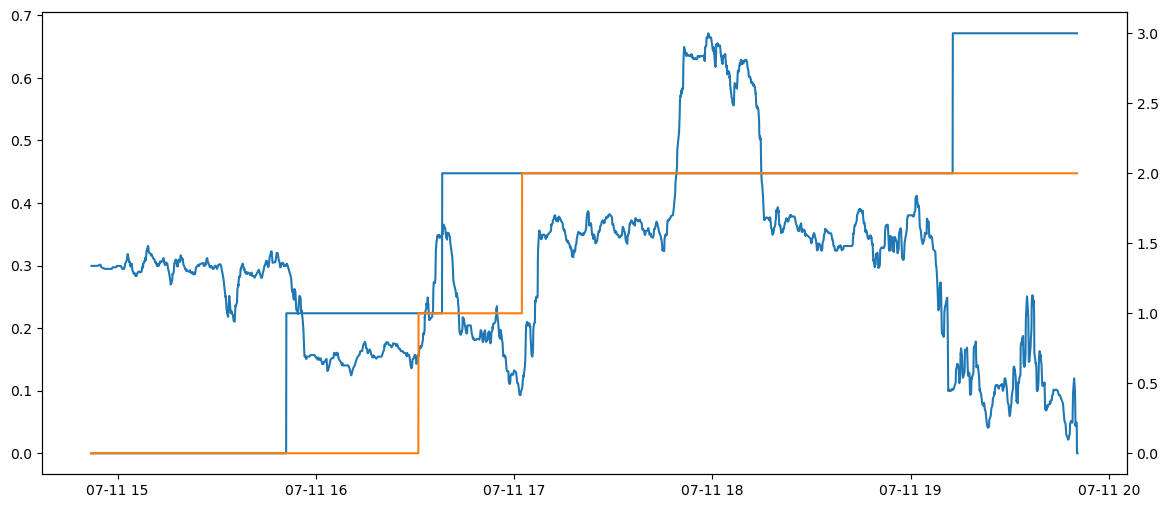

In [8]:
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(df['avg'])
ax2 = ax.twinx()
ax2.plot(df_score['r2_setscore'])
ax2.plot(df_score['r1_setscore'])

In [9]:
df_runner_1 = best_available_df(runner_list_1, start, end)
df_runner_1

,back,lay,back_vol,lay_vol,back-lay avg,spread,vol diff,uncertainty,pup
2018-07-11 14:52:06,3.500000,3.250000,454.270000,1286.340000,3.375000,0.250000,-832.070000,0.074074,0.260983
2018-07-11 14:52:08,3.493092,3.250000,454.220039,1286.340000,3.371546,0.243092,-832.119961,0.072101,0.260962
2018-07-11 14:52:10,3.477632,3.250000,454.098698,1286.340000,3.363816,0.227632,-832.241302,0.067671,0.260910
2018-07-11 14:52:12,3.460033,3.250000,453.959512,1286.340000,3.355016,0.210033,-832.380488,0.062603,0.260851
2018-07-11 14:52:14,3.441579,3.250000,453.813188,1286.340000,3.345789,0.191579,-832.526812,0.057260,0.260789
...,...,...,...,...,...,...,...,...,...
2018-07-11 19:50:20,8.748117,8.115244,16.060136,18.877628,8.431681,0.632873,-2.817492,0.075059,0.459678
2018-07-11 19:50:22,8.758326,8.361578,15.935783,17.754440,8.559952,0.396749,-1.818657,0.046349,0.473009
2018-07-11 19:50:24,8.767420,8.607911,15.750485,16.703715,8.687665,0.159509,-0.953229,0.018360,0.485314
2018-07-11 19:50:26,8.775397,8.854244,15.504243,15.725454,8.814821,-0.078847,-0.221211,-0.008945,0.496458


In [10]:
df_runner_2 = best_available_df(runner_list_2, start, end)
df_runner_2

,back,lay,back_vol,lay_vol,back-lay avg,spread,vol diff,uncertainty,pup
2018-07-11 14:52:06,1.460000,1.406364,4770.900000,11552.636667,1.433182,0.053636,-6781.736667,0.037425,0.292271
2018-07-11 14:52:08,1.460000,1.413182,4770.900000,14378.233333,1.436591,0.046818,-9607.333333,0.032590,0.249144
2018-07-11 14:52:10,1.453333,1.405455,4770.744294,10981.494298,1.429394,0.047879,-6210.750004,0.033496,0.302861
2018-07-11 14:52:12,1.450000,1.401591,4770.531695,9282.935157,1.425795,0.048409,-4512.403462,0.033952,0.339456
2018-07-11 14:52:14,1.450167,1.401390,4770.260407,9148.384243,1.425779,0.048776,-4378.123837,0.034210,0.342724
...,...,...,...,...,...,...,...,...,...
2018-07-11 19:50:20,1.089170,1.051940,28524.977817,16878.277977,1.070555,0.037229,11646.699840,0.034776,0.628258
2018-07-11 19:50:22,1.086170,1.050944,27671.434487,15265.285644,1.068557,0.035226,12406.148843,0.032966,0.644470
2018-07-11 19:50:24,1.083170,1.050026,26819.596487,13652.293310,1.066598,0.033144,13167.303176,0.031075,0.662672
2018-07-11 19:50:26,1.080170,1.049185,25969.090487,12039.300977,1.064677,0.030985,13929.789510,0.029103,0.683246


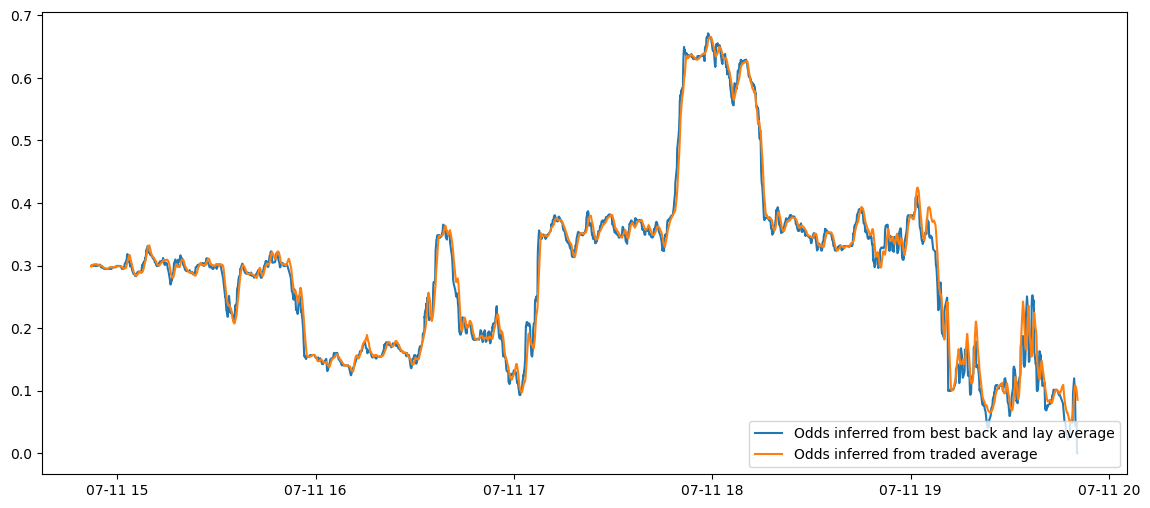

In [11]:
df_avg = df['avg']
df_blodds = ( 1 / df_runner_1['back-lay avg'] + 1 - 1 / df_runner_2['back-lay avg'] ) / 2
df_odds = pd.concat([df_avg, df_blodds], axis=1)
df_odds.columns = ['ltp odds', 'back lay odds']
df_odds
plt.figure(figsize=(14,6))
plt.plot(df_odds)
plt.legend(['Odds inferred from best back and lay average', 'Odds inferred from traded average'], loc='lower right')

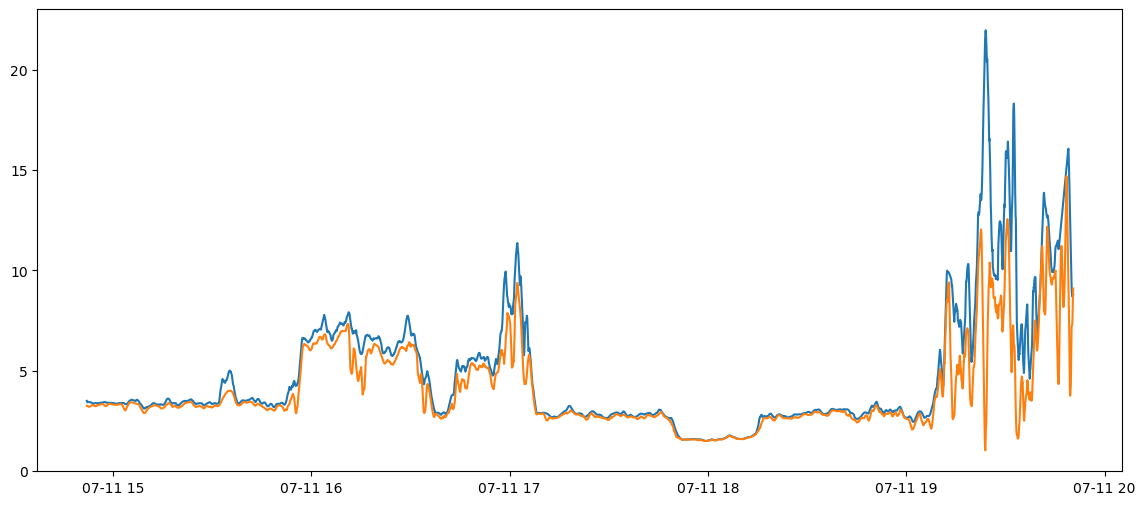

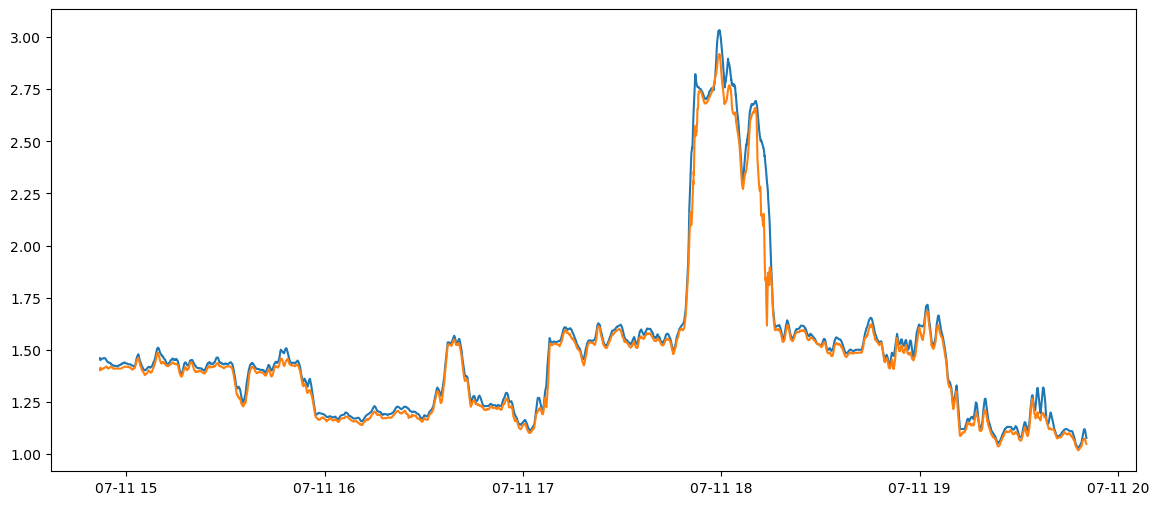

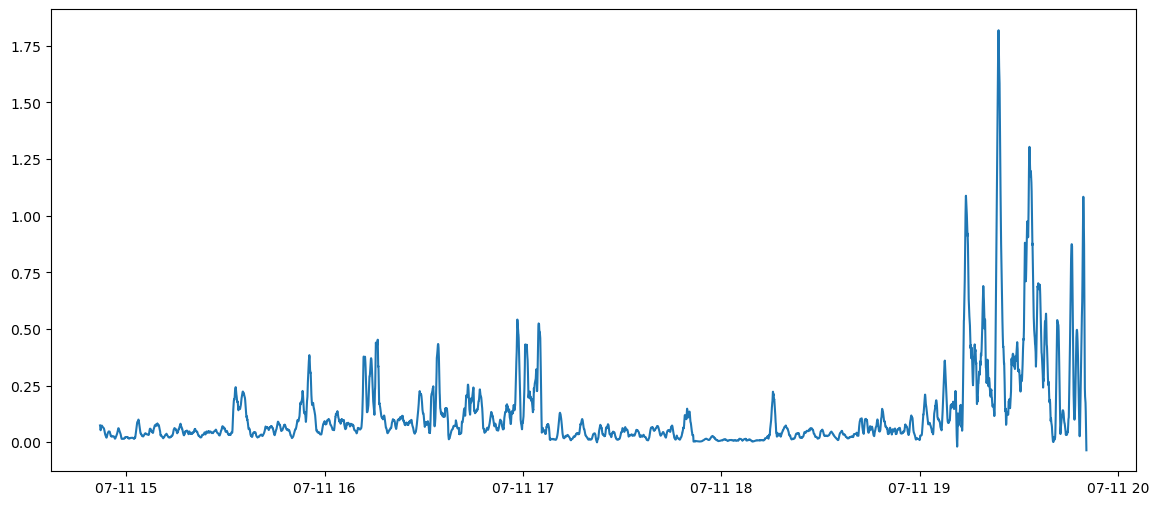

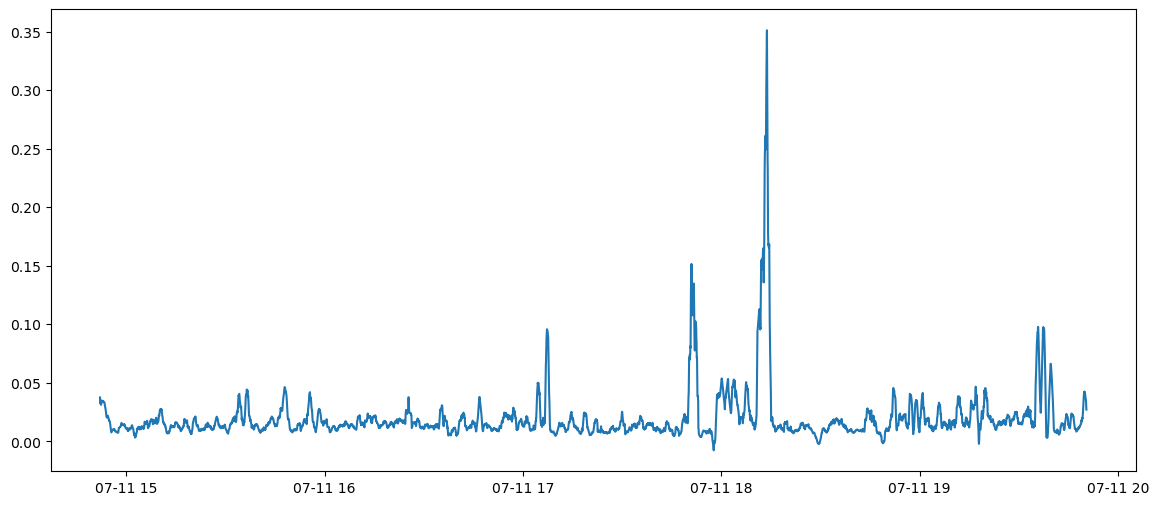

In [12]:
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['back','lay']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['back','lay']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['uncertainty']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['uncertainty']])

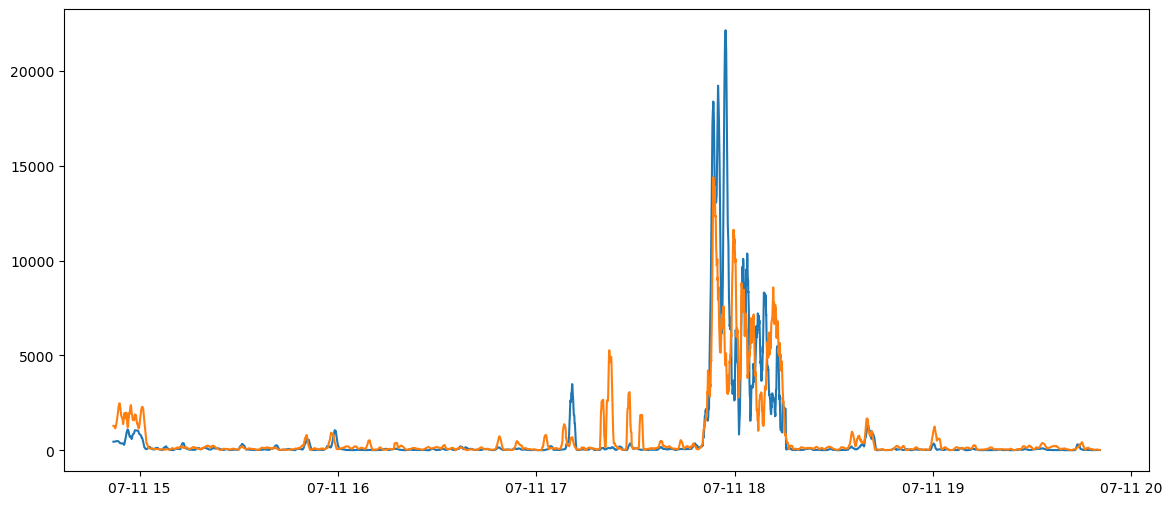

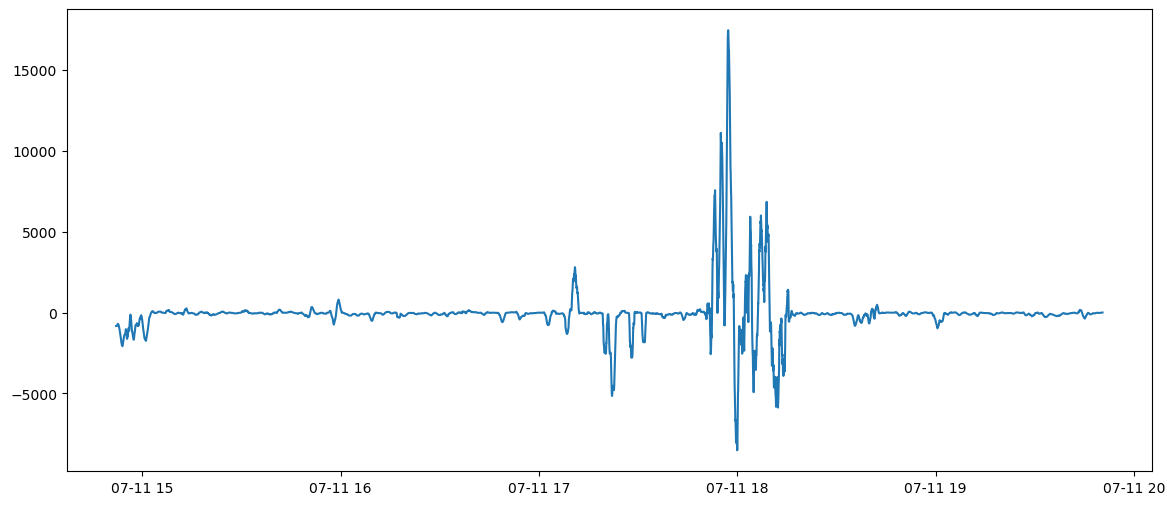

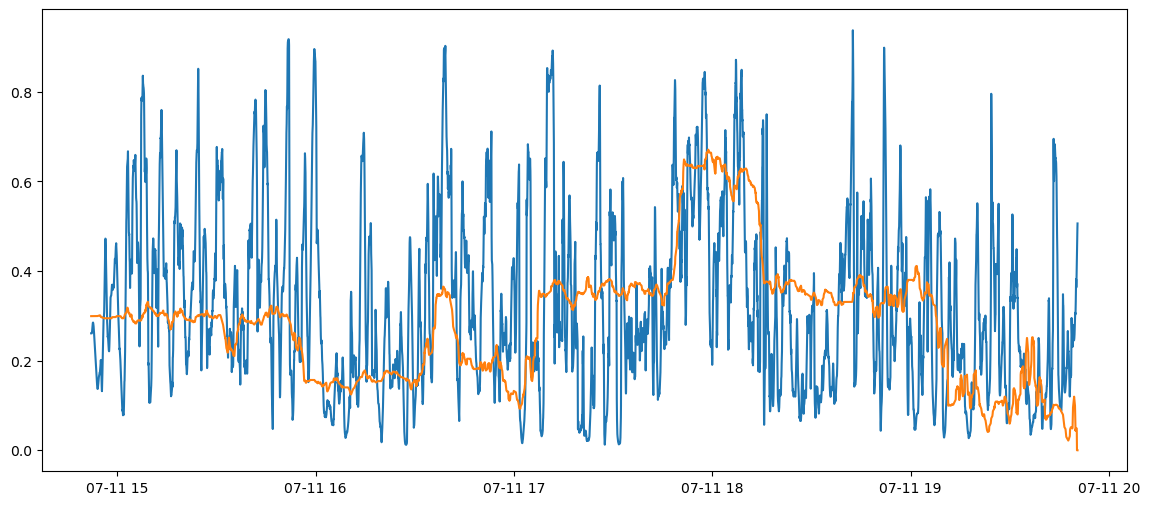

In [13]:
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['back_vol']])
plt.plot(df_runner_1[['lay_vol']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['vol diff']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['pup']])
plt.plot(df_odds['ltp odds'])

,lpt odds,r1 spread,r1 pup,r2 spread,r2 pup,r1_setscore,r2_setscore
2018-07-11 14:52:06,0.299402,0.074074,0.260983,0.037425,0.292271,3.0,3.0
2018-07-11 14:52:08,0.299402,0.072101,0.260962,0.032590,0.249144,3.0,3.0
2018-07-11 14:52:10,0.299402,0.067671,0.260910,0.033496,0.302861,3.0,3.0
2018-07-11 14:52:12,0.299402,0.062603,0.260851,0.033952,0.339456,3.0,3.0
2018-07-11 14:52:14,0.299402,0.057260,0.260789,0.034210,0.342724,3.0,3.0
...,...,...,...,...,...,...,...
2018-07-11 19:50:20,0.000000,0.075059,0.459678,0.034776,0.628258,1.0,0.0
2018-07-11 19:50:22,0.000000,0.046349,0.473009,0.032966,0.644470,1.0,0.0
2018-07-11 19:50:24,0.000000,0.018360,0.485314,0.031075,0.662672,1.0,0.0
2018-07-11 19:50:26,0.000000,-0.008945,0.496458,0.029103,0.683246,1.0,0.0


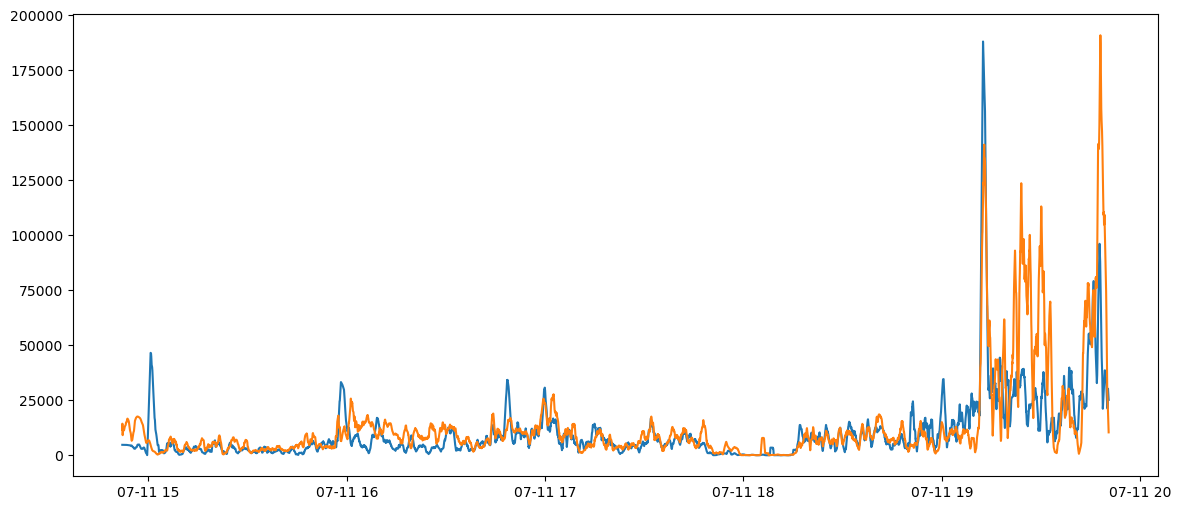

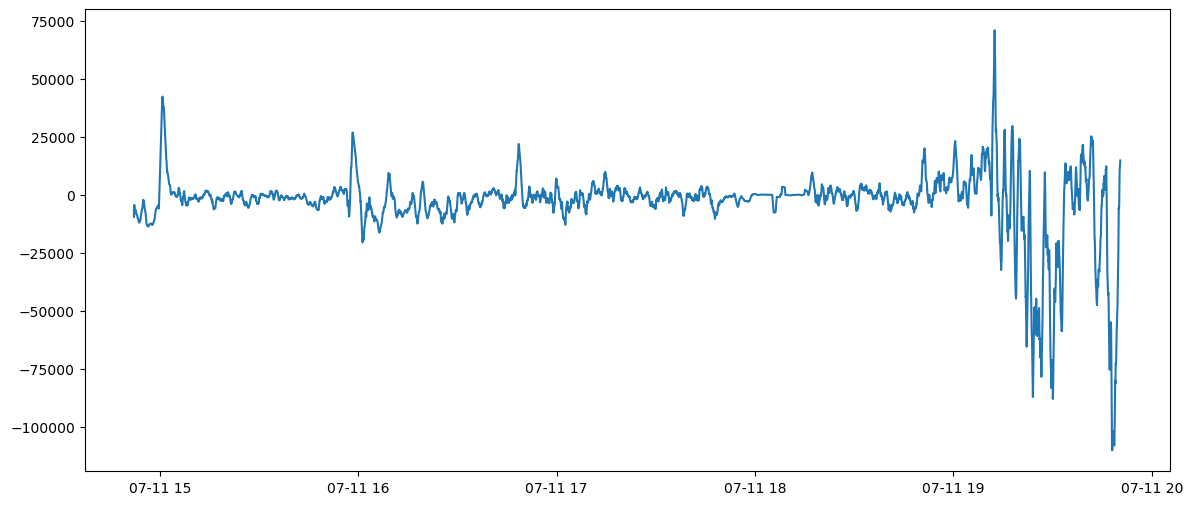

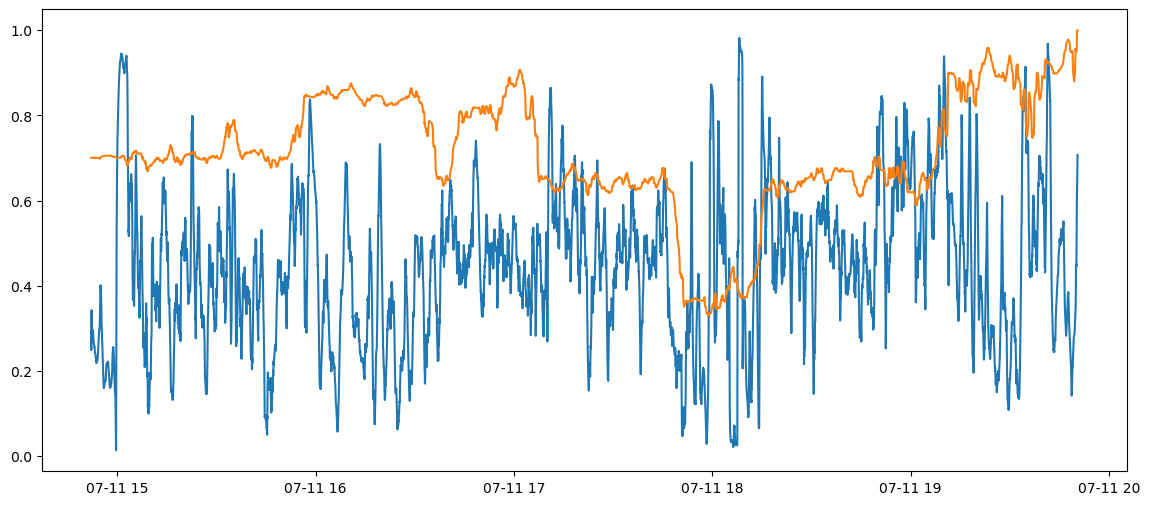

In [16]:
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['back_vol']])
plt.plot(df_runner_2[['lay_vol']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['vol diff']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['pup']])
plt.plot(1 - df_odds['ltp odds'])
df_total = pd.DataFrame({'lpt odds': df_odds['ltp odds'], 'r1 spread': df_runner_1['uncertainty'], 'r1 pup': df_runner_1['pup'], 'r2 spread': df_runner_2['uncertainty'], 'r2 pup': df_runner_2['pup'], 'r1_setscore': 3 - df_score['r1_setscore'], 'r2_setscore': 3 - df_score['r2_setscore']}, index=df_odds.index)
df_total.replace(to_replace=np.nan, method='ffill', inplace=True)
df_total.to_csv('Datatest/1.csv')
df_total